<a href="https://colab.research.google.com/github/YanaSemenenya/INTERPRETATOR/blob/develop/Examples/Economic_effect_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk Prediction
**Xin Zhao**
<br>
This is a case study on Home Credit Default Risk Prediction using data from Home Credit Group and various machine learning algorithms. Techniques on feature selection and principal component analysis are also considered. In the end, XGBoost algorithm is selected. The prediction AUC score is 0.75. 

### Загрузка данных

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"falconwatch","key":"852b6d7f11534bcc686e2d63c56e894e"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'home-credit-default-risk'

 96% 73.0M/76.3M [00:02<00:00, 25.7MB/s]
100% 76.3M/76.3M [00:02<00:00, 36.8MB/s]
 90% 87.0M/96.7M [00:02<00:00, 44.9MB/s]
100% 96.7M/96.7M [00:02<00:00, 40.9MB/s]
 88% 50.0M/56.8M [00:01<00:00, 32.3MB/s]
100% 56.8M/56.8M [00:01<00:00, 48.8MB/s]
 86% 5.00M/5.81M [00:00<00:00, 26.1MB/s]
100% 5.81M/5.81M [00:00<00:00, 28.4MB/s]
 76% 28.0M/36.8M [00:00<00:00, 27.4MB/s]
100% 36.8M/36.8M [00:00<00:00, 57.9MB/s]
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 59.2MB/s]
 97% 264M/271M [00:05<00:00, 43.7MB/s]
100% 271M/271M [00:05<00:00, 49.8MB/s]
 91% 33.0M/36.1M [00:00<00:00, 32.9MB/s]
100% 36.1M/36.1M [00:00<00:00, 49.2MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 37.8MB/s]
 95% 103M/109M [00:03<00:00, 36.5MB/s] 
100% 109M/109M [00:04<00:00, 24.0MB/s]


In [4]:
! unzip application_train.csv.zip application_train.csv
! unzip application_test.csv.zip application_test.csv
! unzip bureau.csv.zip bureau.csv

Archive:  application_train.csv.zip
  inflating: application_train.csv   
Archive:  application_test.csv.zip
  inflating: application_test.csv    
Archive:  bureau.csv.zip
  inflating: bureau.csv              


### Импортируем библиотеки

In [95]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib, matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb
from tqdm import tqdm

In [6]:
from collections import defaultdict

# Explore and process bureau data

In [7]:
bureau = pd.read_csv('bureau.csv')

## Shape

In [8]:
bureau.shape

(1716428, 17)

## Categorical features in bureau

In [9]:
cat_features = bureau.select_dtypes(include='object').columns.tolist()
cat_features

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']


## Label encode the categorical features

In [10]:
bureau_transform = bureau.copy()

In [11]:
encoded_features = defaultdict(dict)
for col in cat_features:
    label_encoder = LabelEncoder()
    uniq_labels = bureau_transform[col].unique()
    bureau_transform[col] = label_encoder.fit_transform(bureau_transform[col])
    encoded_features[col] = dict(zip(uniq_labels,label_encoder.transform(uniq_labels)))

In [12]:
encoded_features

defaultdict(dict,
            {'CREDIT_ACTIVE': {'Active': 0,
              'Bad debt': 1,
              'Closed': 2,
              'Sold': 3},
             'CREDIT_CURRENCY': {'currency 1': 0,
              'currency 2': 1,
              'currency 3': 2,
              'currency 4': 3},
             'CREDIT_TYPE': {'Another type of loan': 0,
              'Car loan': 1,
              'Cash loan (non-earmarked)': 2,
              'Consumer credit': 3,
              'Credit card': 4,
              'Interbank credit': 5,
              'Loan for business development': 6,
              'Loan for purchase of shares (margin lending)': 7,
              'Loan for the purchase of equipment': 8,
              'Loan for working capital replenishment': 9,
              'Microloan': 10,
              'Mobile operator loan': 11,
              'Mortgage': 12,
              'Real estate loan': 13,
              'Unknown type of loan': 14}})

In [13]:
#feature_encode = onehot_encoder.get_feature_names(cat_features)
#bureau_cat_encode.columns = feature_encode
#bureau_cat_encode

## Extract numerical features and combine into the encoded categorical data

In [14]:
#num_features = ['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT']
#bureau_num = bureau[num_features] 
#bureau_proc = pd.concat([bureau_num, bureau_cat_encode], axis=1)
#print(bureau_proc.shape)
#print(bureau_num.shape)
#print(bureau_cat_encode.shape)

## Group sum and mean bureau data by loan ID

In [15]:
bureau_proc_sum = bureau_transform.groupby(['SK_ID_CURR']).sum()
bureau_proc_mean = bureau_transform.groupby(['SK_ID_CURR']).mean()

### Rename columns

In [16]:
new_collist_sum = []
for col in bureau_proc_sum.columns:
    if col == 'SK_ID_CURR':
        continue
    new_collist_sum.append(col + ' SUMBYID')
colname_dict = dict(zip(bureau_proc_sum.columns, new_collist_sum))
bureau_proc_sum = bureau_proc_sum.rename(columns=colname_dict)

In [17]:
new_collist_mean = []
for col in bureau_proc_mean.columns:
    if col == 'SK_ID_CURR':
        continue
    new_collist_mean.append(col + ' MEANBYID')
colname_dict_mean = dict(zip(bureau_proc_mean.columns, new_collist_mean))
bureau_proc_mean = bureau_proc_mean.rename(columns=colname_dict_mean)

### MERGE mean and sum bureau data

In [18]:
bureau_proc_final = pd.merge(bureau_proc_sum, bureau_proc_mean, how='left', on='SK_ID_CURR')

In [19]:
bureau_proc_final.to_csv('bureau_proc_final.csv', index=True)

In [20]:
bureau_proc_final = pd.read_csv('bureau_proc_final.csv')

# Process application_train/test

In [21]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')

## Check if 'SK_ID_CURR' in the train data

In [22]:
'SK_ID_CURR' in application_train.columns

True

## Merge bureau_proc_final to application data

In [23]:
train_merged = pd.merge(application_train, bureau_proc_final, how='left', on='SK_ID_CURR')
test_merged = pd.merge(application_test, bureau_proc_final, how='left', on='SK_ID_CURR')
print(application_train.shape)
print(train_merged.shape)
print(application_test.shape)
print(test_merged.shape)

(307511, 122)
(307511, 154)
(48744, 121)
(48744, 153)


## Drop ID columns for training

In [24]:
train_merged.drop('SK_ID_CURR', axis=1, inplace=True)
test_merged.drop('SK_ID_CURR', axis=1, inplace=True)

### DROP SOME FEATURES

In [25]:
features_to_drop = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE']
for feature in train_merged.columns:
    if 'FLAG_DOCUMENT' in feature:
        features_to_drop.append(feature)
train_merged.drop(features_to_drop, axis = 1, inplace = True)
test_merged.drop(features_to_drop, axis = 1, inplace = True)

### ADD NEW FEATURES

In [26]:
train_merged['PRICE/CREDIT'] = train_merged['AMT_GOODS_PRICE']/train_merged['AMT_CREDIT']
test_merged['PRICE/CREDIT'] = test_merged['AMT_GOODS_PRICE']/test_merged['AMT_CREDIT']

## Extract numerical and categorical features for further processing: impute, scaling

In [27]:
num_features_1 = train_merged.select_dtypes(include='int64').columns.tolist()
num_features_1.remove('TARGET')

In [28]:
num_features_2 = train_merged.select_dtypes(include='float64').columns.tolist()

In [29]:
cat_features = train_merged.select_dtypes(include='object').columns.tolist()

In [30]:
num_features = num_features_1 + num_features_2
features = num_features + cat_features

### EDA

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

 ### Обработка данных


Заполняем пропущенные значеня в вещественных фичах

In [32]:
for feature in num_features:
    fill_value = train_merged[feature].mean()
    train_merged[feature].fillna(fill_value, inplace = True)
    test_merged[feature].fillna(fill_value, inplace = True)

In [33]:
np.sum(train_merged[num_features].isna().sum() != 0)

0

Заполняем пропущенные значения в категориальных фичах и делаем лейбл энкодинг

In [34]:
for feature in cat_features:
    train_merged[feature].fillna('missing', inplace = True)
    test_merged[feature].fillna('missing', inplace = True)
    label_encoder = LabelEncoder()
    uniq_labels = train_merged[feature].unique()
    train_merged[feature] = label_encoder.fit_transform(train_merged[feature])

    encoded_features[feature] = dict(zip(uniq_labels,label_encoder.transform(uniq_labels)))
    test_merged[feature] = label_encoder.transform(test_merged[feature])

In [35]:
train_merged[cat_features].isna().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
ORGANIZATION_TYPE             0
FONDKAPREMONT_MODE            0
HOUSETYPE_MODE                0
WALLSMATERIAL_MODE            0
EMERGENCYSTATE_MODE           0
dtype: int64

### Сохраняем данные и делим выделяем таргер

In [36]:
#train_merged['AGE/EXPERIENCE'] = train_merged['DAYS_BIRTH']/train_merged['DAYS_EMPLOYED']
#test_merged['AGE/EXPERIENCE'] = test_merged['DAYS_BIRTH']/test_merged['DAYS_EMPLOYED']

In [37]:
train_merged.to_csv('train_merged.csv', index= False)
test_merged.to_csv('test_merged.csv', index = False)


In [38]:
X_train = train_merged.drop(['TARGET'], axis = 1)
X_test = test_merged.copy()
y_train = train_merged.TARGET.values
print('X_train shape:', X_train.shape)

X_train shape: (307511, 128)


### TRAINING difficult Model

In [39]:
from lightgbm import LGBMClassifier

In [40]:
from xgboost import XGBClassifier

In [41]:
difficult_model_2 = LGBMClassifier(random_state=42, eval_metric="auc", max_depth=4,learning_rate=0.277, gamma=0.382)

difficult_model_2.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', gamma=0.382, importance_type='split',
               learning_rate=0.277, max_depth=4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [42]:
#difficult_model = LGBMClassifier(random_state=42, eval_metric="auc", max_depth=4,learning_rate=0.277, gamma=0.382)

difficult_model = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", 
                              max_depth=4,learning_rate=0.277, gamma=0.382)

difficult_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.382, learning_rate=0.277, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
import sklearn.metrics as metrics
def plot_AUC(model,X_test,y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc*2-1

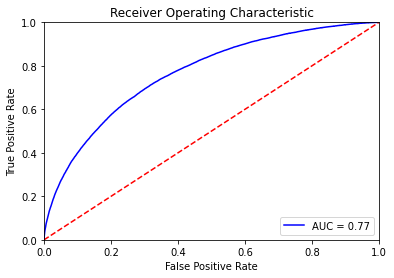

0.5324742200590096

In [44]:
plot_AUC(difficult_model, X_train, y_train)

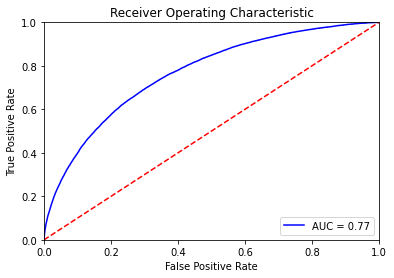

0.5341854955924572

In [45]:
plot_AUC(difficult_model_2, X_train, y_train)

In [46]:
dif_model_predicted = [p[1] for p in difficult_model.predict_proba(X_train)]
dif_model_2_predicted = [p[1] for p in difficult_model_2.predict_proba(X_train)]

# Train logreg

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
feature_imp = sorted([(f,i) for f,i in zip(X_train.columns, difficult_model.feature_importances_)], key = lambda x: x[1], reverse=True)
selected_features = [f[0] for f in feature_imp[:20]]

In [49]:
logreg_model = LogisticRegression(random_state=42, max_iter=10000)
logreg_model.fit(X_train[selected_features], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

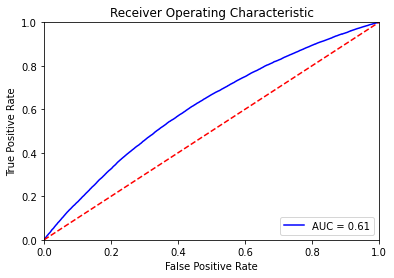

0.22697810449449185

In [50]:
plot_AUC(logreg_model, X_train[selected_features], y_train)

# Оценка экономического эффекта

In [51]:
data_analysis = X_train.copy()

logreg_predictions = [p[1] for p in logreg_model.predict_proba(X_train[selected_features])]

data_analysis['logreg_pd'] = logreg_predictions
data_analysis['diff_pd'] = dif_model_predicted
data_analysis['diff_2_pd'] = dif_model_2_predicted
data_analysis['target'] = y_train

## Оценка по RWA

In [52]:
from scipy.stats import norm
import math

def get_rwa(my_pd, my_lgd, my_ead, my_r=0.03):
    k = (norm.cdf((norm.ppf(my_pd) + np.sqrt(my_r) * norm.ppf(0.999))/(np.sqrt(1-my_r))) - my_pd) * my_lgd
    rwa = k * 12.5 * my_ead
    return rwa

def eval_model(dataset, pd_column = 'pd_ttc', default_column = 'default_12m', ead_column = 'balance_at_report_dt'):
    g = roc_auc_score(dataset[default_column], dataset[pd_column])*2-1
    rwa_arr = get_rwa(dataset[pd_column], 0.72, dataset[ead_column])
    #rwa_ead_arr = rwa_arr / dataset[ead_column]
    rwa = rwa_arr.sum()/dataset[ead_column].sum()
    return g, rwa

def model_enchancment_profit(eads, rwa_base, rwa_adv):
  return np.sum(eads) * (rwa_base - rwa_adv)

In [53]:
def rwa_two_models(base_pd, adv_pd):
  print("Базовая модель")
  base_model = eval_model(data_analysis, pd_column=base_pd, default_column='target', ead_column='AMT_CREDIT')
  base_gini = base_model[0]
  base_rwa_rub = base_model[1]
  base_rwa = data_analysis['AMT_CREDIT'].sum() * base_rwa_rub
  print('Gini: ', base_gini)
  print('RWA на рубль: ', base_rwa_rub)
  print('RWA всего: ',base_rwa)
  print('-------------------------------')

  print("Продвинутая модель")
  advanced_model = eval_model(data_analysis, pd_column=adv_pd, default_column='target', ead_column='AMT_CREDIT')
  adv_gini = advanced_model[0]
  adv_rwa_rub = advanced_model[1]
  adv_rwa = data_analysis['AMT_CREDIT'].sum() * adv_rwa_rub
  print('Gini: ', adv_gini)
  print('RWA на рубль: ', adv_rwa_rub)
  print('RWA всего: ', adv_rwa)
  print('-------------------------------')

  print("Экономический эффект от улучшения модели")
  print(model_enchancment_profit(data_analysis['AMT_CREDIT'], base_rwa_rub, adv_rwa_rub))  
  return {'base_gini':base_gini, 'base_rwa_rub':base_rwa_rub, 'base_rwa':base_rwa, 
          'adv_gini':adv_gini, 'adv_rwa_rub':adv_rwa_rub, 'adv_rwa':adv_rwa}

In [54]:
print("База - xgb, продвинутый  - lgbm")
dif_models_comp = rwa_two_models('diff_pd', 'diff_2_pd')
dif_models_comp

База - xgb, продвинутый  - lgbm
Базовая модель
Gini:  0.5324742200590096
RWA на рубль:  0.8373997355922147
RWA всего:  154254963599.52454
-------------------------------
Продвинутая модель
Gini:  0.5341854955924572
RWA на рубль:  0.8327243152449018
RWA всего:  153393718049.9577
-------------------------------
Экономический эффект от улучшения модели
861245549.566829


{'adv_gini': 0.5341854955924572,
 'adv_rwa': 153393718049.9577,
 'adv_rwa_rub': 0.8327243152449018,
 'base_gini': 0.5324742200590096,
 'base_rwa': 154254963599.52454,
 'base_rwa_rub': 0.8373997355922147}

In [55]:
print("База - логрег, продвинутый  - xgb")
logreg_xgb_comp = rwa_two_models('logreg_pd', 'diff_pd')
logreg_xgb_comp

База - логрег, продвинутый  - xgb
Базовая модель
Gini:  0.22697810449449185
RWA на рубль:  0.8777520031655204
RWA всего:  161688137149.8798
-------------------------------
Продвинутая модель
Gini:  0.5324742200590096
RWA на рубль:  0.8373997355922147
RWA всего:  154254963599.52454
-------------------------------
Экономический эффект от улучшения модели
7433173550.355264


{'adv_gini': 0.5324742200590096,
 'adv_rwa': 154254963599.52454,
 'adv_rwa_rub': 0.8373997355922147,
 'base_gini': 0.22697810449449185,
 'base_rwa': 161688137149.8798,
 'base_rwa_rub': 0.8777520031655204}

### Динамика

In [92]:
k=0.3

def improve_logreg(k):
  selected_index = np.random.choice(data_analysis.index.values, int(data_analysis.shape[0]*k), replace=False)
  old_pds = data_analysis['logreg_pd'].copy()
  old_pds.loc[selected_index] = data_analysis.loc[selected_index, 'diff_pd']
  data_analysis['improved_pd'] = old_pds
  new_model = eval_model(data_analysis, pd_column='improved_pd', default_column='target', ead_column='AMT_CREDIT')
  return new_model

In [96]:
improvement_log = list()
for k in tqdm(range(101)):
  improvement_log.append(improve_logreg(k/100))

100%|██████████| 101/101 [00:21<00:00,  4.67it/s]


In [99]:
improvement_ginis = [l[0] for l in improvement_log]
improvement_rwa_rub = [l[1] for l in improvement_log]

Text(0, 0.5, 'RWA на рубль Exposure')

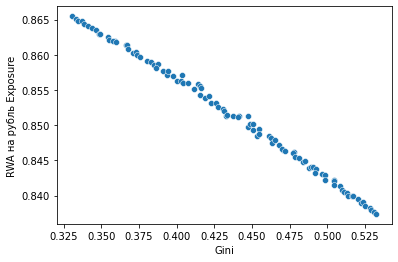

In [107]:
sns.scatterplot(x = improvement_ginis, y = improvement_rwa_rub)
plt.xlabel('Gini')
plt.ylabel('RWA на рубль Exposure')

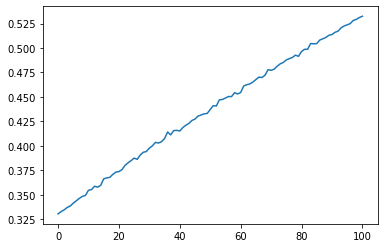

In [100]:
plt.plot(improvement_ginis)

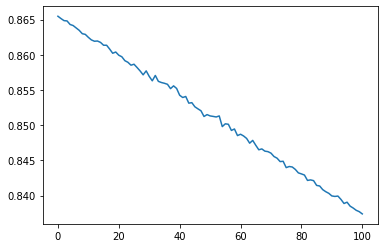

In [108]:
plt.plot(improvement_rwa_rub)

In [75]:
data_analysis['diff_pd']
data_analysis['logreg_pd']

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU SUMBYID,CREDIT_ACTIVE SUMBYID,CREDIT_CURRENCY SUMBYID,DAYS_CREDIT SUMBYID,CREDIT_DAY_OVERDUE SUMBYID,DAYS_CREDIT_ENDDATE SUMBYID,DAYS_ENDDATE_FACT SUMBYID,AMT_CREDIT_MAX_OVERDUE SUMBYID,CNT_CREDIT_PROLONG SUMBYID,AMT_CREDIT_SUM SUMBYID,AMT_CREDIT_SUM_DEBT SUMBYID,AMT_CREDIT_SUM_LIMIT SUMBYID,AMT_CREDIT_SUM_OVERDUE SUMBYID,CREDIT_TYPE SUMBYID,DAYS_CREDIT_UPDATE SUMBYID,AMT_ANNUITY SUMBYID,SK_ID_BUREAU MEANBYID,CREDIT_ACTIVE MEANBYID,CREDIT_CURRENCY MEANBYID,DAYS_CREDIT MEANBYID,CREDIT_DAY_OVERDUE MEANBYID,DAYS_CREDIT_ENDDATE MEANBYID,DAYS_ENDDATE_FACT MEANBYID,AMT_CREDIT_MAX_OVERDUE MEANBYID,CNT_CREDIT_PROLONG MEANBYID,AMT_CREDIT_SUM MEANBYID,AMT_CREDIT_SUM_DEBT MEANBYID,AMT_CREDIT_SUM_LIMIT MEANBYID,AMT_CREDIT_SUM_OVERDUE MEANBYID,CREDIT_TYPE MEANBYID,DAYS_CREDIT_UPDATE MEANBYID,AMT_ANNUITY MEANBYID,PRICE/CREDIT,logreg_pd,diff_pd,diff_2_pd,target
0,0,1,0,1,0,202500.000,406597.500,24700.500,351000.000,6,7,4,3,1,0.019,-9461,-637,-3648.000,-2120,12.061,1,0,1,0,8,1.000,2,2,6,10,0,0,0,0,0,0,5,0.025,0.037,0.972,...,0.000,0.000,1.000,49226177.000,12.000,0.000,-6992.000,0.000,-2094.000,-4185.000,8405.145,0.000,865055.565,245781.000,31988.565,0.000,28.000,-3999.000,0.000,6153272.125,1.500,0.000,-874.000,0.000,-349.000,-697.500,1681.029,0.000,108131.946,49156.200,7997.141,0.000,3.500,-499.875,0.000,0.863,0.156,0.231,0.227,1
1,0,0,0,0,0,270000.000,1293502.500,35698.500,1129500.000,1,4,1,1,1,0.004,-16765,-1188,-1186.000,-291,12.061,1,0,1,0,3,2.000,1,1,1,11,0,0,0,0,0,0,39,0.096,0.053,0.985,...,0.000,0.000,0.000,23543514.000,6.000,0.000,-5603.000,0.000,-2178.000,-3292.000,0.000,0.000,1017400.500,0.000,810000.000,0.000,14.000,-3264.000,0.000,5885878.500,1.500,0.000,-1400.750,0.000,-544.500,-1097.333,0.000,0.000,254350.125,0.000,202500.000,0.000,3.500,-816.000,16052.247,0.873,0.026,0.014,0.010,0
2,1,1,1,1,0,67500.000,135000.000,6750.000,135000.000,6,7,4,3,1,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,0,8,1.000,2,2,1,9,0,0,0,0,0,0,11,0.117,0.088,0.978,...,0.000,0.000,0.000,13658267.000,4.000,0.000,-1734.000,0.000,-977.000,-1065.000,0.000,0.000,189037.800,0.000,0.000,0.000,6.000,-1064.000,0.000,6829133.500,2.000,0.000,-867.000,0.000,-488.500,-532.500,0.000,0.000,94518.900,0.000,0.000,0.000,3.000,-532.000,16052.247,1.000,0.073,0.031,0.040,0
3,0,0,0,1,0,135000.000,312682.500,29686.500,297000.000,6,7,4,0,1,0.008,-19005,-3039,-9833.000,-2437,12.061,1,0,0,0,8,2.000,2,2,6,17,0,0,0,0,0,0,5,0.117,0.088,0.978,...,0.267,0.265,1.900,32757264.929,7.030,0.005,-6359.786,4.943,2575.655,-3573.598,7733.043,0.040,1955806.586,640650.257,23563.475,223.034,18.620,-3335.532,20059.614,5890848.443,1.178,0.001,-1083.047,1.036,651.808,-970.305,5242.425,0.008,378080.201,160390.077,5901.476,49.549,3.364,-546.632,16052.247,0.950,0.060,0.074,0.067,0
4,0,1,0,1,0,121500.000,513000.000,21865.500,513000.000,6,7,4,3,1,0.029,-19932,-3038,-4311.000,-3458,12.061,1,0,0,0,3,1.000,2,2,4,11,0,0,0,0,1,1,37,0.117,0.088,0.978,...,0.000,0.000,0.000,5987200.000,2.000,0.000,-1149.000,0.000,-783.000,-783.000,0.000,0.000,146250.000,0.000,0.000,0.000,3.000,-783.000,0.000,5987200.000,2.000,0.000,-1149.000,0.000,-783.000,-783.000,0.000,0.000,146250.000,0.000,0.000,0.000,3.000,-783

In [ ]:
### 

## Оценка по доходности

In [56]:
def get_profit(pds, defaults, margins, eads, lgds = 0.72, th=0.04):
    predicted_class = (pds>th).astype(int)
    tn, fp, fn, tp = confusion_matrix(defaults, predicted_class).ravel()
    profit = np.sum(tn*margins - fp*margins - fn*eads*lgds)/np.sum(eads)
    return profit

In [57]:
def analize_profits(model_pd):
  profits = list()
  for t in range(50):
    th = t/100
    profit = get_profit(pds = data_analysis[model_pd], 
                defaults = data_analysis['target'], 
                margins = data_analysis['AMT_CREDIT']*0.1, 
                eads = data_analysis['AMT_CREDIT'],
                th=th)
    profits.append(profit)
  return profits

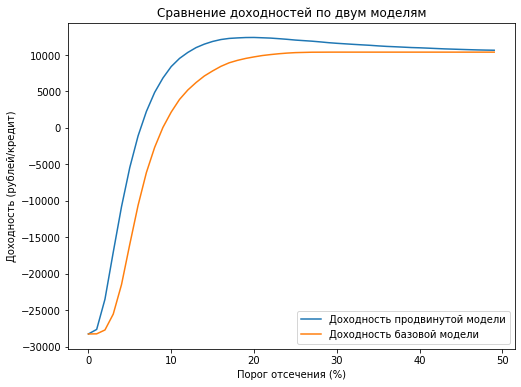

In [70]:
profits_logreg = analize_profits('logreg_pd')
profits_xgb = analize_profits('diff_pd')

plt.figure(figsize=[8,6])
plt.plot(profits_xgb, label="Доходность продвинутой модели")
plt.plot(profits_logreg, label="Доходность базовой модели")
plt.xlabel('Порог отсечения (%)')
plt.ylabel('Доходность (рублей/кредит)')
plt.title("Сравнение доходностей по двум моделям")
plt.legend()

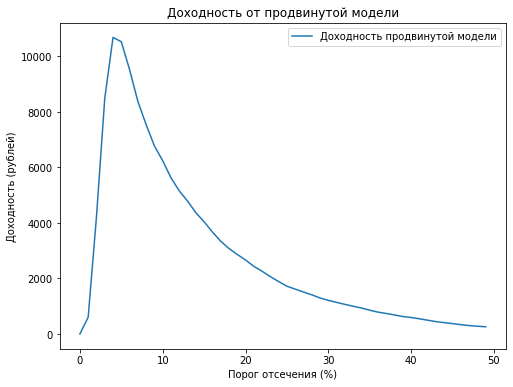

In [67]:
profit_difference = np.array(profits_xgb) - np.array(profits_logreg)

plt.figure(figsize=[8,6])
plt.plot(profit_difference, label="Доходность продвинутой модели")
plt.xlabel('Порог отсечения (%)')
plt.ylabel('Доходность (рублей)')
plt.title("Доходность от продвинутой модели")
plt.legend()

In [59]:
def profit_comparisson(base_profits, adv_profits, total_count):
  base_best_profit = np.max(base_profits)
  adv_best_profit = np.max(adv_profits)
  base_total_profit = base_best_profit * total_count
  adv_total_profit = adv_best_profit * total_count

  return {'base_best_profit':base_best_profit, 
          'base_total_profit':base_total_profit, 
          'adv_best_profit':adv_best_profit, 
          'adv_total_profit':adv_total_profit}


In [60]:
logreg_xgb_profits_comp = profit_comparisson(profits_logreg, profits_xgb, X_train.shape[0])
logreg_xgb_profits_comp

{'adv_best_profit': 12406.199999999999,
 'adv_total_profit': 3815042968.2,
 'base_best_profit': 10395.44,
 'base_total_profit': 3196712149.84}

## Таблица сравнения логрега и бустинга

In [61]:
comparisson = pd.DataFrame()

In [62]:
comparisson.loc['gini', 'Логрег']=logreg_xgb_comp['base_gini']
comparisson.loc['gini', 'Бустинг']=logreg_xgb_comp['adv_gini']

comparisson.loc['Максимальная средняя доходность с кредита', 'Логрег']=logreg_xgb_profits_comp['base_best_profit']
comparisson.loc['Максимальная средняя доходность с кредита', 'Бустинг']=logreg_xgb_profits_comp['adv_best_profit']

comparisson.loc['Максимальный доход с потока (млн. руб)', 'Логрег']=round(logreg_xgb_profits_comp['base_total_profit']/1000000, 0)
comparisson.loc['Максимальный доход с потока (млн. руб)', 'Бустинг']=round(logreg_xgb_profits_comp['adv_total_profit']/1000000, 0)

comparisson.loc['RWA на рубль EAD', 'Логрег']=logreg_xgb_comp['base_rwa_rub']
comparisson.loc['RWA на рубль EAD', 'Бустинг']=logreg_xgb_comp['adv_rwa_rub']

comparisson.loc['RWA (млн. руб)', 'Логрег']=round(logreg_xgb_comp['base_rwa']/1000000)
comparisson.loc['RWA (млн. руб)', 'Бустинг']=round(logreg_xgb_comp['adv_rwa']/1000000)

In [73]:
comparisson['Изменение'] = comparisson['Бустинг'] - comparisson['Логрег']
comparisson['Относительное изменение (%)'] = comparisson['Изменение'] / comparisson['Логрег'] *100

In [74]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
comparisson

,Логрег,Бустинг,Изменение,Относительное изменение,Относительное изменение (%)
gini,0.227,0.532,0.305,1.346,134.593
Максимальная средняя доходность с кредита,10395.440,12406.200,2010.760,0.193,19.343
Максимальный доход с потока (млн. руб),3197.000,3815.000,618.000,0.193,19.331
RWA на рубль EAD,0.878,0.837,-0.040,-0.046,-4.597
RWA (млн. руб),161688.000,154255.000,-7433.000,-0.046,-4.597
